In [49]:
### Download, Inspect and Upload Permit Data
from open_mastr import Mastr
import pandas as pd
import geopandas as gpd
import supabase_py
import psycopg2
import sqlalchemy
import os
import numpy as np
from dotenv import load_dotenv
from pandas.api.types import is_datetime64_any_dtype
from datetime import datetime
import time
import seaborn as sns

In [ ]:
### Data was already downloaded with open_mastr into local sqllite DB
db = Mastr()
conn = db.engine # Connection engine

df_permit = pd.read_sql_table("permit", conn)
columns_permit = list(df_permit.columns)

In [ ]:
### function to turn CamelCase to snake_case
def change_case(str):
    # List comprehension, starts with an _ wich is removed by lstrip("_")
    # loops through word, if upper, _ first "_"+
    # and i.lower() as a string method
    # just return i else
    return ''.join(['_'+i.lower() if i.isupper() 
               else i for i in str]).lstrip('_')
    
def dtype_sqltype(str, map_dict):
    
    # next() jumps through the iterator until a match is found
    # with a an iterator generated by the comprehension inside ()
    return next((key for key, val in map_dict.items() if val == str), None)

In [ ]:
### How many are linked to windpower-data?
df_permit.info() # VerknuepfteEinheiten as Foreign-Key column

### Open Windpower-Data
### Connect to the database
# downloaded certiticate
# Set connection details in .env

# Load environment variables from .env file
load_dotenv()

# Get connection parameters from environment variables
dbname = os.getenv("DB_NAME")
user = os.getenv("DB_USER")
password = os.getenv("DB_PASSWORD")
host = os.getenv("DB_HOST")
port = os.getenv("DB_PORT")
ssl_cert_path = os.getenv("SSL_CERT_PATH")

# Construct the connection string
conn_str = f"dbname={dbname} user={user} password={password} host={host} port={port} sslmode=require sslrootcert={ssl_cert_path}"

# Etablish connection object

#conn.close()
conn = psycopg2.connect(conn_str)

In [ ]:
### Get windpower-Data
# Mastr-Einheiten-Nummer
# Spalte in permit verknüpfte Einheiten als array
# Welche enthalten Wind-Einheiten -> Sind unter diesen jeweils alle eines Arrays bekannte Windeinheiten?

# Nur die mit Wind in die Datenbank schreiben, 
# Genehmigungsnummer als FK zu permits als Spalte in wind_extended hinzufügen
# Welche Constraints sind sinnvoll?

In [ ]:
sql_select = "SELECT * FROM public.wind_extended;"
df_wind = pd.read_sql(sql_select, conn)

In [ ]:
# One item of df_permit["Verknuefte_Einheiten"]: "hdjsahd98698, 875875hjhjhj, 65654dhdf"
rows = []

for index,row in df_permit.iterrows():
    permit = row["GenMastrNummer"]
    units = row["VerknuepfteEinheiten"].split(", ")
    
    for unit in units:
        rows.append({"GenMastrNummer": permit, "Einheit": unit})

df_permits_units = pd.DataFrame(rows)
df_permits_units.info()

In [ ]:
cols_keep = ['id', 'name_windpark','eeg_mastr_nummer',
             'einheit_systemstatus',
       'einheit_betriebsstatus',      
       'einheit_mastr_nummer', 
       'registrierungsdatum',
       'meldedatum', 'geplantes_inbetriebnahmedatum', 'inbetriebnahmedatum',
       'datum_endgueltige_stilllegung',
       'datum_beginn_voruebergehende_stilllegung',
       'datum_beendigung_vorlaeufigen_stilllegung',
       'datum_wiederaufnahme_betrieb',
       'datum_letzte_aktualisierung']
df_wind_perm = df_wind[cols_keep]

In [ ]:
df_permits_wind = pd.merge(df_permits_units, df_wind_perm, 
                           left_on="Einheit", right_on="einheit_mastr_nummer",
                           how="outer")

# Wie viele aus Wind haben eine Genehmigung
# Wie ist der Betriebsstatus

# Wie viele aus Permit sind in Wind?
# Gibt es Dopplungen:
# Eine Anlage aus Wind -> mehrere Genehmigungen?
# Eine Genehmigung

# Sind alle Genehmigungen Unique -> in df_permit überprüfen
len(df_permit.GenMastrNummer)           # 30684
len(df_permit.GenMastrNummer.unique())  # 30684

# Sind bis auf NaN alle Einheiten (.Einheit = alle verknüpften Einheiten in df_permit, .einheit_mastr_nummer = Windkraft-Einheiten)
# Unique?
ind = df_permits_wind.einheit_mastr_nummer.notna()
len(df_permits_wind.einheit_mastr_nummer[ind])           # 35227
len(df_permits_wind.einheit_mastr_nummer[ind].unique())  # 35227
len(df_wind)                                             # 35227

# Wie sind die Genehmigungen verteilt?
# df beschränken auf notna() -> ind von oben
df_permits_wind = df_permits_wind.loc[ind,:]

# Haben alle eine Einheiten eine Genehmigung
df_permits_wind.GenMastrNummer.notna().sum()            # 26545/35227 -> > 2/3 der Einheiten haben eine Genehmigungsnummer
# Wie verteilt sich der Betriebsstatus der Anlagen ohne Genehmigung?
ind = df_permits_wind.GenMastrNummer.isna()
df_permits_wind.loc[ind,:].groupby('einheit_betriebsstatus')['einheit_mastr_nummer'].count()

ind = df_permits_wind.GenMastrNummer.notna()
# 7922 Einheiten ohne verknüpfte Genehmigung (8682) sind in Betrieb

# Anzahl verbleibender Genehmigungen
len(df_permits_wind.GenMastrNummer[ind].unique())       # 15748


In [ ]:
# Tabelle genehmigungen erstellen
# Welches ist die Datengrundlage?
# Inhalte/Typen überprüfen
# Insert Statement schreiben
# Genehmigungsnummer als Primary-key setzen
columns_remove = df_permit.columns[[11,14,15,16]]
columns_permit = [col for col in df_permit.columns if col not in columns_remove]

gen_number = df_permits_wind.GenMastrNummer[df_permits_wind.GenMastrNummer.notna()]
df_permit_upload = df_permit[df_permit['GenMastrNummer'].isin(gen_number)]
df_permit_upload = df_permit_upload[columns_permit]
df_permit_upload.info()


In [ ]:
### Set schema_name and table_name
schema_name = "public"
table_name = "permits"

### Get python data types
pd_types = [df_permit_upload[col].dtype for col in columns_permit]

# dictionary mapping the data types: Postgres Data type = pandas data type
map_types = {'bool': 'bool', 
                 'float8': 'float64', 
                 'date' : '<M8[ns]', 
                 'varchar':'O'}

pk_column = "GenMastrNummer"


In [ ]:
sql_columns = []
for col in columns_permit:
    if col not in pk_column:
    # SQL create column statement for this column: 'column_name pgsql-type,'. Leave out constraints for now
    # to lowercase, underscore at uppercase
        name = change_case(col)
        sql_type = dtype_sqltype(df_permit_upload[col].dtype, map_types)
        sql_columns.append(f"{name} {sql_type}")
        
sql_columns = ", \n ".join(sql_columns)

sql_pk = f"{change_case(pk_column)} {dtype_sqltype(df_permit_upload[pk_column].dtype, map_types)} PRIMARY KEY"

In [ ]:
### PK-column
# leave out geo-columns -> added later on
# add primary key
sql_drop = f"DROP TABLE IF EXISTS {schema_name}.{table_name};"

sql_create = f"""
CREATE TABLE {schema_name}.{table_name} (
{sql_pk},
{sql_columns} 
);""" 

In [ ]:
print(conn)
conn_cursor = conn.cursor()

# drop table if it already exists
conn_cursor.execute(sql_drop)

# table creation
conn_cursor.execute(sql_create)
conn.commit()

conn_cursor.close()

In [ ]:
### Helper Function for one preprocessed row without geodata 
### to generate column names and values

def row_data_to_sql(row_data, columns_data):
    ### Lists for column names as needed for the postgres-table and the values as given to the sql statement
    columns_sql = []
    values_sql = []

    for col in columns_data:
        val = row_data[col].values[0]
        # print(val)
        # print(type(val))
        
    # Test wether the column holds a value and is not empty
        if pd.notna(val):
        # add column name
            columns_sql.append(change_case(col))
        # Apply date to string transformation
            if isinstance(val, str):
                #print("is_str")
                values_sql.append(f"$${val}$$")   # add a pair of parentheses to keep for the join
            elif is_datetime64_any_dtype(val):
                #print("is_datetime")
                val = np.datetime_as_string(val, unit="D")
                values_sql.append(f"'{val}'")
            else:
                #print("is_float_bool")
                values_sql.append(str(val))     # cast to str without adding parentheses
    
    return columns_sql, values_sql

In [ ]:
### helper function to construct the INSERT query for one row 
#   from the columns_sql and values_sql lists

def join_insert_sql(columns_sql, values_sql):
    # join sql-column names and values respectively into a single string
    columns_sql = ", \n ".join(columns_sql) 
    values_sql = ", \n ".join(values_sql)

    # Create INSERT-Query for one row
    sql_insert = f"""INSERT INTO {schema_name}.{table_name} (
        {columns_sql} )
    VALUES (
        {values_sql}
        );
    """
    
    return sql_insert

In [ ]:
### Function for all rows
def df_to_sql_insert(df_permits_upload, conn_db):
    # join sql-column names and values respectively into a single string
    ### Loop through columns
    ### How should the geo-insert look like
    columns_wind = df_permits_upload.columns

    ### column names where each name corresponds to one value (not true for db column geom) 
    columns_data = columns_wind #[col for col in columns_wind if col not in geo_columns]
    
    ### List to hold all INSERT Statements
    inserts_all = []
    
    for i in range(len(df_permits_upload)):
        row_wind = df_permits_upload.iloc[[i],:]
        
        row_data = row_wind[columns_data]    
        #row_geo = row_wind[geo_columns]
        
        columns_sql, values_sql = row_data_to_sql(row_data, columns_data)
        #columns_sql, values_sql = row_geo_to_sql(row_geo, geo_columns, columns_sql, values_sql)
        insert_sql = join_insert_sql(columns_sql, values_sql)
        
        inserts_all.append(insert_sql)
    
    inserts_all_sql = " \n ".join(inserts_all)
    
        # Establish a connection to the database    
    try:
        # Create a cursor
        cur = conn_db.cursor()
    
        # Execute your SQL statement
        cur.execute(inserts_all_sql)
    
        # Commit the transaction
        conn.commit()
    
    except Exception as e:
        # Handle the exception
        print(f"Error: {e}")
        conn.rollback()
    
    finally:
        # Close the cursor and connection
        cur.close()
        #conn.close()
    


In [ ]:
batch_size = 1000  # Set the desired batch size
total_rows = len(df_permit_upload)

for i in range(0, total_rows, batch_size):
    df_batch = df_permit_upload[i:i+batch_size]
    df_to_sql_insert(df_batch, conn)

In [ ]:
### gen_mastr_nummer is already within the wind_extended data
### Foreign Key constraint needs to be set
schema_name = "public"
table_name = "wind_extended"
table_name_2 = "permits"

foreign_key_column = change_case("GenMastrNummer")

sql_foreign_key = f"""
    ALTER TABLE {schema_name}.{table_name}
    ADD CONSTRAINT foreign_key_{foreign_key_column} 
    FOREIGN KEY ({foreign_key_column})
    REFERENCES {schema_name}.{table_name_2} ({foreign_key_column});
    """

### Not necessary, since information_schema.columns revealed, that the column is already nullable
sql_drop_not_null_fk = f"""
    ALTER TABLE {schema_name}.{table_name} 
    ALTER COLUMN {foreign_key_column} DROP NOT NULL;
"""

print(conn)
conn_cursor = conn.cursor()

# Add foreign key constraint
conn_cursor.execute(sql_foreign_key)
#conn_cursor.execute(sql_drop_not_null_fk)
conn.commit()

conn_cursor.close()

### Foreign-Key column was not explicitly set to null Documentation and Chat-GPT unclear wether this is a good solution

In [ ]:
### Check wether the join wind_extended-permits is the same as df_permits_units
sql_join = """
SELECT wind.gen_mastr_nummer as gen_wind,
permits.gen_mastr_nummer as gen_permits, 
wind.einheit_mastr_nummer as einheit_wind 
FROM public.wind_extended as wind
LEFT JOIN public.permits as permits
ON wind.gen_mastr_nummer = permits.gen_mastr_nummer
ORDER BY gen_wind;
"""  

df_join_wind_permits = pd.read_sql(sql_join, conn)

In [ ]:
df_join_wind_permits

In [ ]:
df_permits_units

In [ ]:
df_join_test = pd.merge(df_join_wind_permits, df_permits_units, 
                           left_on="einheit_wind", right_on="Einheit",
                           how="left")

In [ ]:
# gen_wind = gen_permits?
# GenMastrNummer == gen_wind?
# einheit_wind == Einheit

gen_join_test = []
gen_join_mastr_test = []
gen_join_mastr_einheit_test = []
for index, row in df_join_test.iterrows():
    gen_join_test.append(row["gen_wind"] == row["gen_permits"])
    gen_join_mastr_test.append(row["gen_wind"] == row["GenMastrNummer"])
    gen_join_mastr_einheit_test.append(row["einheit_wind"] == row["Einheit"])

In [ ]:
df_join_test["gen_join_test"] = gen_join_test
df_join_test["gen_join_mastr_test"] = gen_join_mastr_test
df_join_test["gen_join_mastr_einheit_test"] = gen_join_mastr_test

In [ ]:
cols = ["gen_join_test","gen_join_mastr_test", "gen_join_mastr_einheit_test"]

test_sums = {}

for col in cols:
    test_sums[col] = df_join_test[col].sum()

print(test_sums)
# 26545 items of gen_wind from wind_extended are the same as from the open_mastr_download -> difference due to those units
# without a permission
# 26545 items of units from wind_extended are the same as from the open_mastr_download of the permits
# The ones without a permission are not included in the permits download

In [ ]:
### Permits - compare te distribution of those with a gen_mastr_nummer to those without
df_wind_date = df_wind[['id', 'einheit_mastr_nummer', 'inbetriebnahmedatum', 'einheit_betriebsstatus', 'gen_mastr_nummer']]

df_wind_date["hat_gen"] = df_wind_date.gen_mastr_nummer.notna()
df_wind_date["jahr"] = df_wind_date.inbetriebnahmedatum.dt.year()


In [68]:
def return_year(x):
    if pd.notna(x):
        return x.year
    else:
        return None

df_wind_date["inbetriebnahme_jahr"] = df_wind_date["inbetriebnahmedatum"].apply(lambda x: return_year(x))

/tmp/ipykernel_9403/2246141858.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wind_date["inbetriebnahme_jahr"] = df_wind_date["inbetriebnahmedatum"].apply(lambda x: return_year(x))


<Axes: xlabel='inbetriebnahme_jahr', ylabel='Count'>

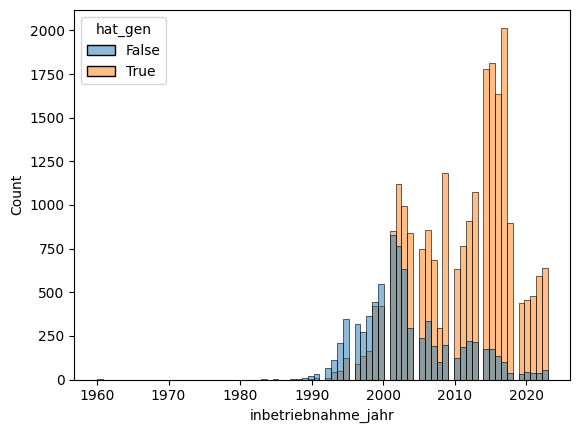

In [70]:
sns.histplot(data = df_wind_date[df_wind_date["einheit_betriebsstatus"] == "In Betrieb"],
             x = "inbetriebnahme_jahr", 
             hue = "hat_gen")